# **CI Course - EX3**

--------

--------


## Theory Overview ##

**Swarm Intelligence:**

In computational swarm intelligence, a group of simple agents or artificial agents called "particles" interact with each other and with their environment to achieve a specific goal.<br/>The agents in the swarm share information with one another and use this information to adapt their behavior to changing circumstances.<br/>Swarm intelligence algorithms are designed to mimic the behavior of natural swarms in order to find solutions to optimization problems or decision-making tasks.

**Particle Swarm Intelligence (PSO):**

Particle swarm intelligence is a swarm intelligence technique that works by iteratively adjusting a population of "particles" according to their own experience and the experience of their neighbors.<br/>Each particle in the swarm represents a potential solution to the optimization problem being solved.<br/>The **position** of each particle represents a potential solution in the search space. <br/>The **velocity** of each particle represents the rate and direction at which the particle moves through the search space.

![particle_pos.png](attachment:ff258682-d231-4dae-94b7-4aaab942ad39.png)

![particle_vel.png](attachment:63cafb18-cb74-47fe-9146-d0edfdf51c67.png)

The particles in the swarm are initialized with random positions and velocities. <br/>In each iteration, each particle updates its velocity and position based on its own best solution (**=cognitive**) and the best solution of its neighbors (**=social**). <br/>This information sharing allows the particles to explore the search space efficiently and converge to an optimal solution.

This method is particularly effective for problems with large search spaces and multiple local optima.

PSO shares many similarities with evolutionary computation techniques such as Genetic Algorithms (GA).<br/>However, unlike GA, PSO has no evolution operators such as crossover and mutation. The difference is in the way the generations are updated.

**pbest vs gbest:**

pbest and gbest refer to the best solutions found by each particle and the swarm, respectively.

pbest represents the personal best solution found by each particle in its own search space. <br/>It is used by the particle to update its velocity and position.

gbest represents the global best solution found by the entire swarm. <br/>It is used by each particle to adjust its search direction and coordinate with the other particles in the swarm.

![particle_update.png](attachment:87f4aa36-a8f5-4e5c-be2a-8fb7d466eec6.png)

Where:

$${w\in [0,w_{limit}]} \: most\:of\:the\:time\:[0,1]$$ 
$${{r_1},{r_2} \in rand[a,b] \: most\:of\:the\:time\:[0,1]}$$
$${{c_1,c_2} \in R^+}$$


**The Optimization coefficients explained:**

These coefficients control the levels of exploration and exploitation.

1. Cognitive acceleration and social acceleration are stochastically adjusted by the weights **r1 and r2**. These two weights r1 and r2 are unique for each particle and each iteration.
2. The hyperparameter **w** allows to define the ability of the swarm to change its direction. The particles have an inertia proportional to this coefficient w. <br/>low coefficient w facilitates the exploitation of the best solutions found so far while a high coefficient w facilitates the exploration around these solutions.
3. The **c1** hyperparameter allows defining the ability of the group to be influenced by the best personal solutions found over the iterations. <br/>The hyperparameter **c2** allows defining the ability of the group to be influenced by the best global solution found over the iterations.

**PSO cycle:**

![PSO_cycle.png](attachment:9c839b76-9736-48d7-91cf-fb2501bfa66b.png)
 
<!-- <img src=assets/PSO_cycle.png width=38% height=38% >
 -->
---


## Exercise - Beam Properties Optimization ##

**Problem:**

The objective is to determine the optimal length of a beam $L$, as well as the optimal radius $R$ and thickness $t$ of its circular profile, to minimize the weight $w$ of the beam subject to a given end load of $F=4000[N]$.

![problem.jpg](attachment:726d04bc-e4da-48c1-9a94-77502d0de29f.jpg)

**We need to find:**

$$(L,R,t)$$ 

such that : $$min[w(L,R,t) + K/L]$$ 

where: 
1. $K = 3.0$ --> is the beam shorten penalty
2. $w(L,R,t) = \pi*{(R^2-{(R-t)^2})*L*\rho}$ 
3. $\rho = 8000 [kg/m^3]$

**Subject to:**

$$ 0.5[m] \le L \le 2.3[m]$$

$$ 0.012[m] \le R \le 0.1[m]$$

$$ 1[m] \le t \le 10[m]$$

$$ \sigma_{max} \le y_{st} = 2100 [MPa]$$ 

where:

$\sigma_{max} = {{FLR}\over{I_c}}$ and ${I_c} = {\pi \over 4}(R^4-{(R-t)^4})$


We will demonstrate PSO soultion with $N=100$ **particles** 

**Important NOTES:**

- Update will be executed only if particle fulfills the conditions
- Stop condition will be triggered on **max iteration** or **gbest is not changing for 50 iterations** 

---

### Solution ###

Flow:

1. Defining constants
2. Declare the objective function and constraints
3. Define search space
4. Implement the PSO cycle

---


#### Import libraries and defining problem constants ####

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

# constants
F = 4000 # N
rho = 8000 # Kg/m^3
max_stress = 2100e6 # N/m^2 = Pa
K = 3.0
stop_iter = 50

#### Define search space ####

In [3]:
# x = [L, R, t] [meters]
x_min = np.array([0.5, 12e-3, 1e-3]).reshape(-1,1) # m, m, m
x_max = np.array([2.3, 100e-3, 10e-3]).reshape(-1,1) # m, m, m, m, m
ndim = len(x_min)
# print(f"shape is like: \n {x_min}")

#### Declare the objective function and constraints ####

In [4]:
def Weight(x):
    L, R, t = x[0], x[1], x[2]
    return np.pi*rho*(R**2 - (R-t)**2)*L + K/L

# x = np.array([1.2,0.03,0.002])
# print(f"Weight example: {Weight(x)} Kg")
      
def Stress(x):
    L, R, t= x[0], x[1], x[2]
    I = (R**4 - (R-t)**4)*np.pi/4
    return F*L*R/I

# print(f"Stress example: {Stress(x)} Pa")

def generate_valid_particles(n_particles, x_min, x_max):
    X = []
    count = 0
    while count < n_particles:
        x = np.random.rand(ndim, 1) * (x_max - x_min) + x_min
        if Stress(x) < max_stress:
            X.append(x)
            count += 1

    X = np.array(X).reshape(n_particles,-1).T
    return X

# P = generate_valid_particles(2,x_min,x_max)
# print(f"Particles genarting example: \n {P}")

# function f(x) takes array of particles and output corresponding weight array
def f(X):
    O = []
    for x in X.T:
        O.append(Weight(x))

    return np.array(O)

# print(f"f(x) example: \n {f(P)}")

#### Implement the PSO cycle ####

Iteration 0 , Best weight so far:  5.586393327365669 ; L=0.815738816736206 R=0.04480922007351325 t=0.0010511965661731608 S=509.7463496760914MPa


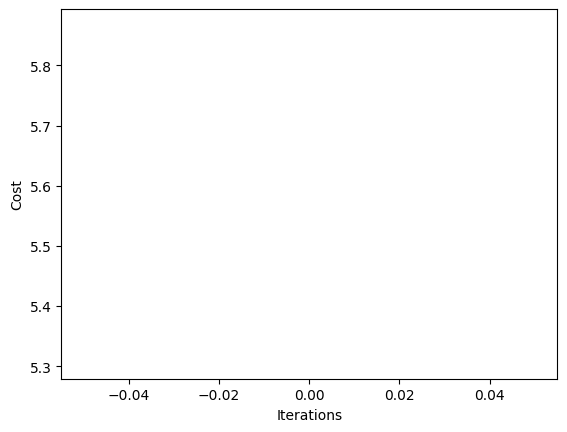

Iteration 1 , Best weight so far:  5.586393327365669 ; L=0.815738816736206 R=0.04480922007351325 t=0.0010511965661731608 S=509.7463496760914MPa


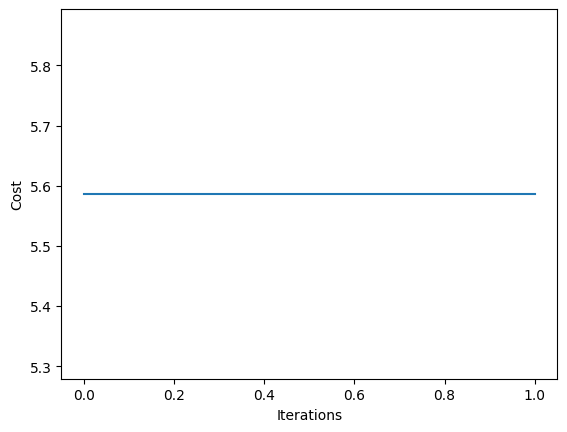

Iteration 2 , Best weight so far:  5.586393327365669 ; L=0.815738816736206 R=0.04480922007351325 t=0.0010511965661731608 S=509.7463496760914MPa


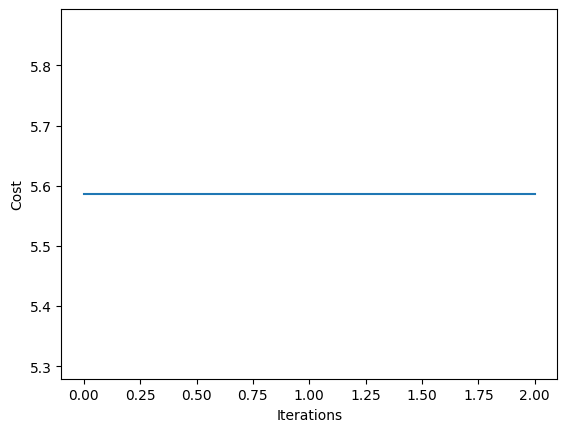

Iteration 3 , Best weight so far:  5.586393327365669 ; L=0.815738816736206 R=0.04480922007351325 t=0.0010511965661731608 S=509.7463496760914MPa


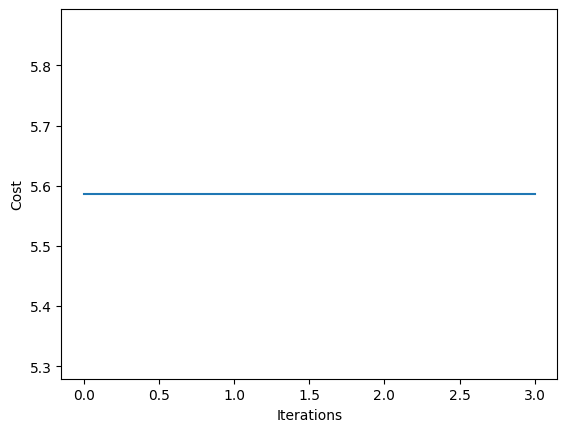

Iteration 4 , Best weight so far:  5.586393327365669 ; L=0.815738816736206 R=0.04480922007351325 t=0.0010511965661731608 S=509.7463496760914MPa


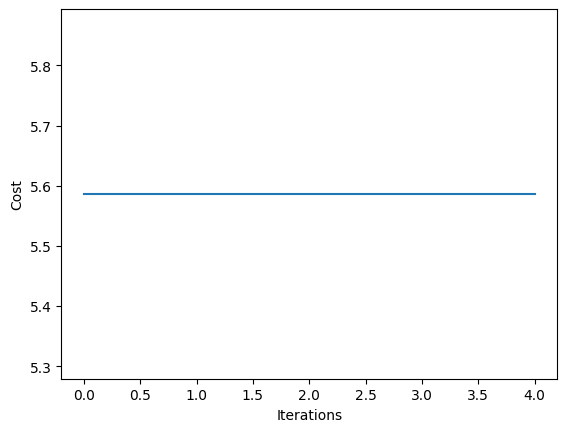

Iteration 5 , Best weight so far:  5.586393327365669 ; L=0.815738816736206 R=0.04480922007351325 t=0.0010511965661731608 S=509.7463496760914MPa


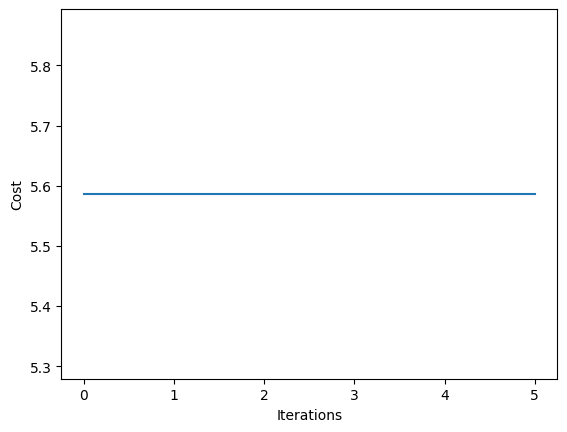

Iteration 6 , Best weight so far:  5.586393327365669 ; L=0.815738816736206 R=0.04480922007351325 t=0.0010511965661731608 S=509.7463496760914MPa


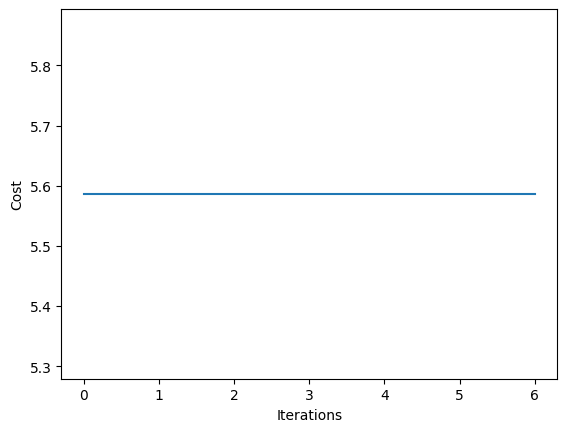

Iteration 7 , Best weight so far:  4.84758264260695 ; L=1.400982765759942 R=0.036380429146128296 t=0.0010721137466845393 S=1314.0436913135231MPa


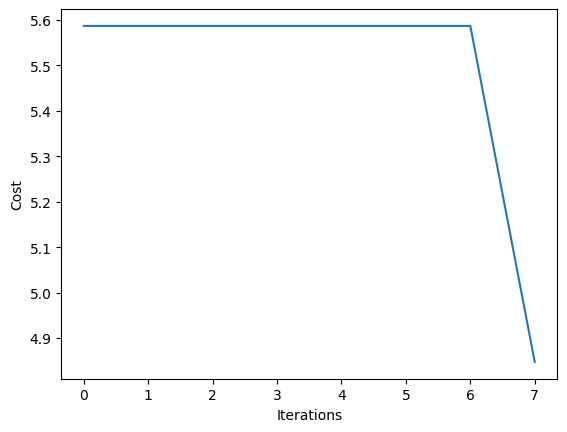

Iteration 8 , Best weight so far:  4.84758264260695 ; L=1.400982765759942 R=0.036380429146128296 t=0.0010721137466845393 S=1314.0436913135231MPa


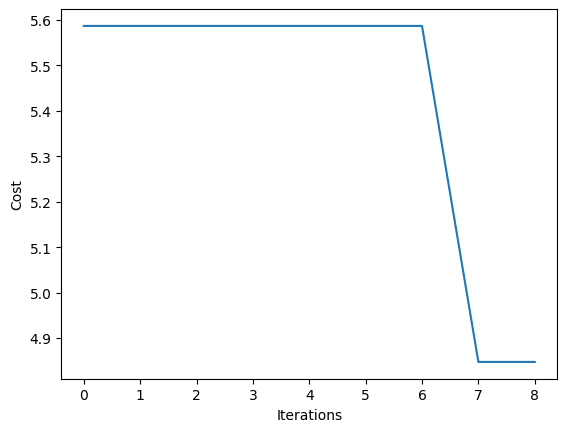

Iteration 9 , Best weight so far:  4.84758264260695 ; L=1.400982765759942 R=0.036380429146128296 t=0.0010721137466845393 S=1314.0436913135231MPa


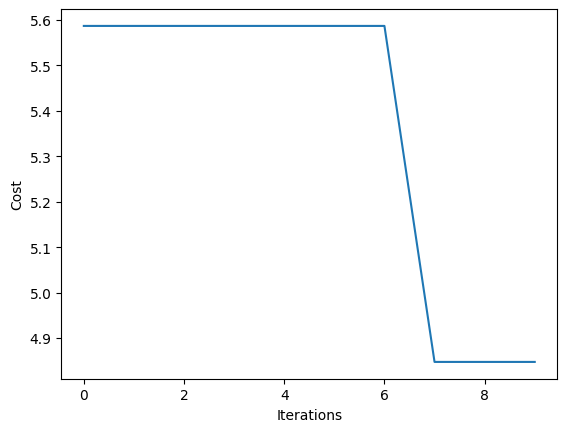

Iteration 10 , Best weight so far:  4.84758264260695 ; L=1.400982765759942 R=0.036380429146128296 t=0.0010721137466845393 S=1314.0436913135231MPa


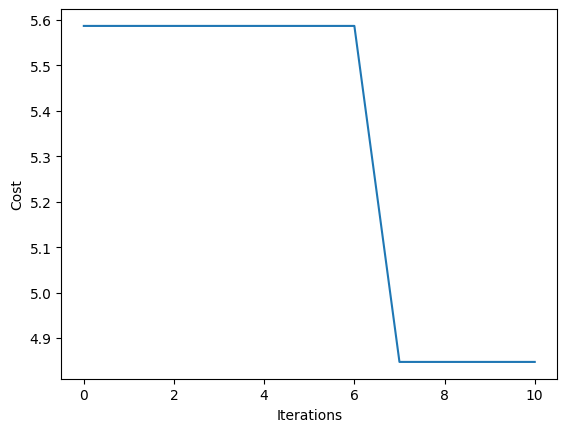

Iteration 11 , Best weight so far:  4.657320475342338 ; L=0.918403890788516 R=0.02457908612203398 t=0.00125790579179844 S=1662.0276522747224MPa


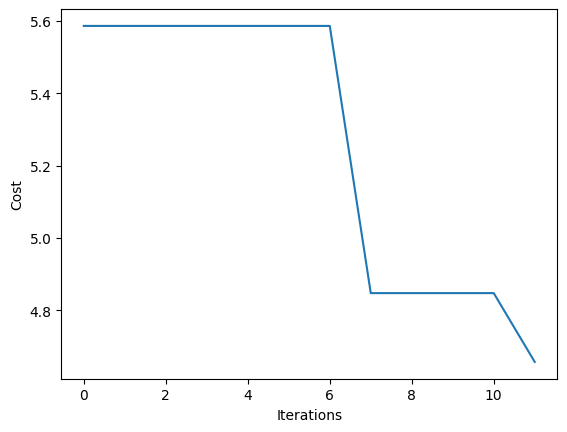

Iteration 12 , Best weight so far:  4.657320475342338 ; L=0.918403890788516 R=0.02457908612203398 t=0.00125790579179844 S=1662.0276522747224MPa


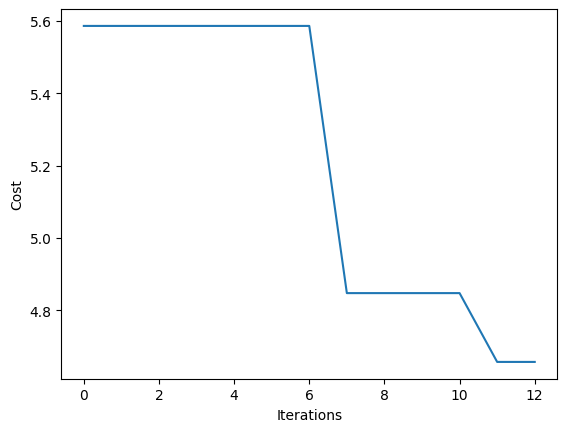

Iteration 13 , Best weight so far:  4.594104258801883 ; L=1.0167189996363148 R=0.030945144717643546 t=0.001057237395132419 S=1346.080628910805MPa


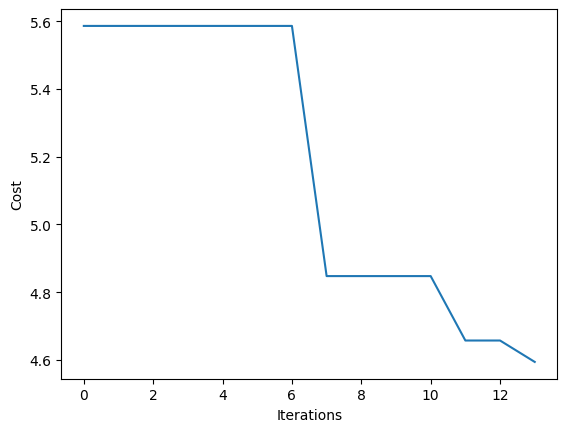

Iteration 14 , Best weight so far:  4.594104258801883 ; L=1.0167189996363148 R=0.030945144717643546 t=0.001057237395132419 S=1346.080628910805MPa


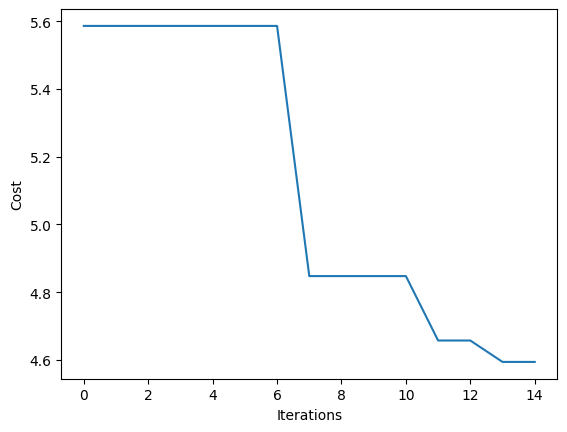

Iteration 15 , Best weight so far:  4.594104258801883 ; L=1.0167189996363148 R=0.030945144717643546 t=0.001057237395132419 S=1346.080628910805MPa


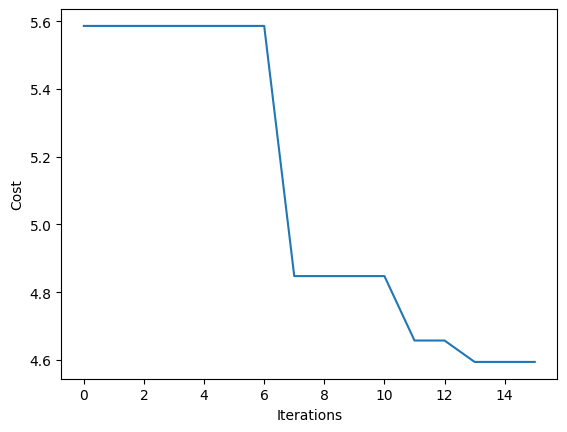

Iteration 16 , Best weight so far:  4.523521561441624 ; L=1.344184531200685 R=0.02607793723988415 t=0.0013347878606488164 S=2036.5199290456783MPa


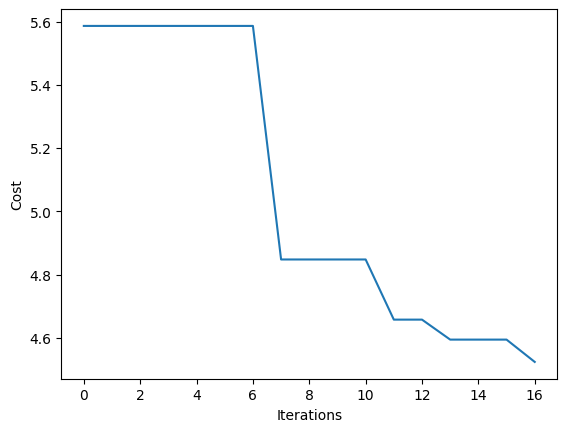

Iteration 17 , Best weight so far:  4.420880171487316 ; L=1.2848541181350461 R=0.02626930043272939 t=0.001259734527462967 S=2022.7682814342763MPa


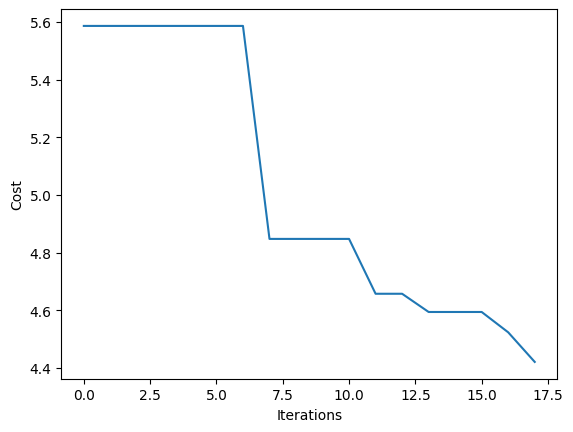

Iteration 18 , Best weight so far:  4.355299922474781 ; L=1.240356308335817 R=0.02641282282736332 t=0.0012034445275735798 S=2014.6044444215036MPa


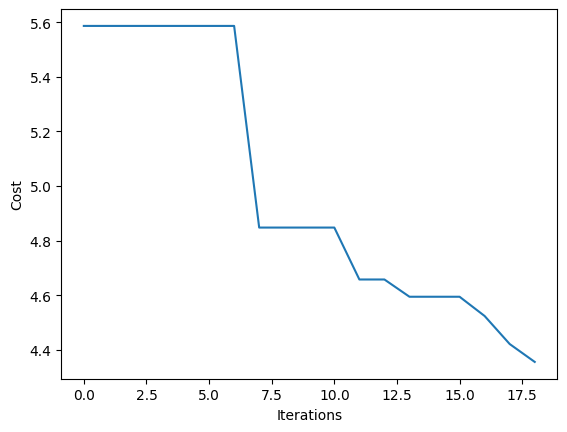

Iteration 19 , Best weight so far:  4.3130288602531595 ; L=1.206982950986395 R=0.026520464623338767 t=0.0011612270276565395 S=2009.8112937159226MPa


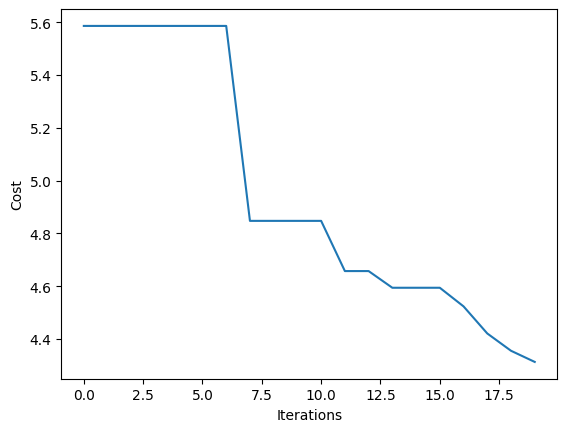

Iteration 20 , Best weight so far:  4.285450149277894 ; L=1.1819529329743286 R=0.026601195970320353 t=0.0011295639027187592 S=2007.0252944472418MPa


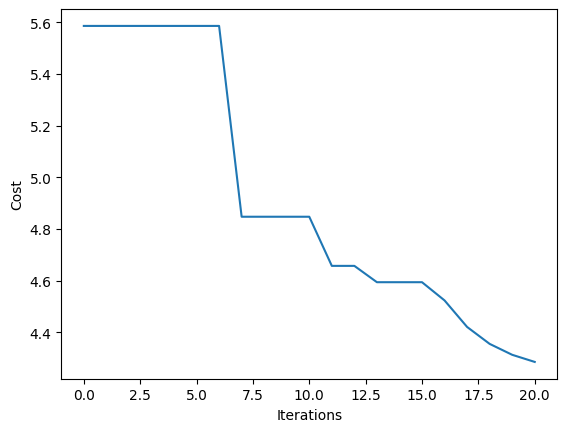

Iteration 21 , Best weight so far:  4.267194260286901 ; L=1.1631804194652788 R=0.026661744480556544 t=0.0011058165590154241 S=2005.4203156124777MPa


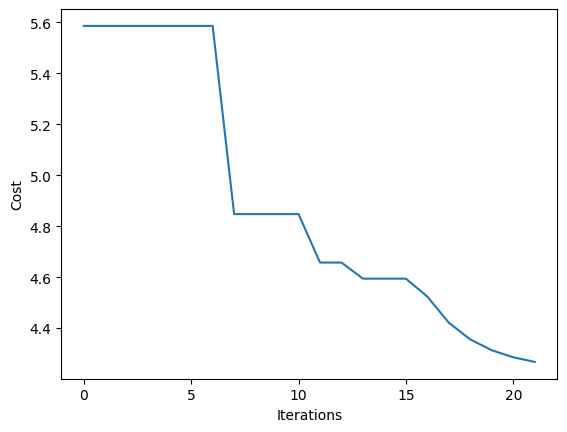

Iteration 22 , Best weight so far:  4.254916863452271 ; L=1.1491010343334915 R=0.026707155863233686 t=0.0010880060512379228 S=2004.5029909803657MPa


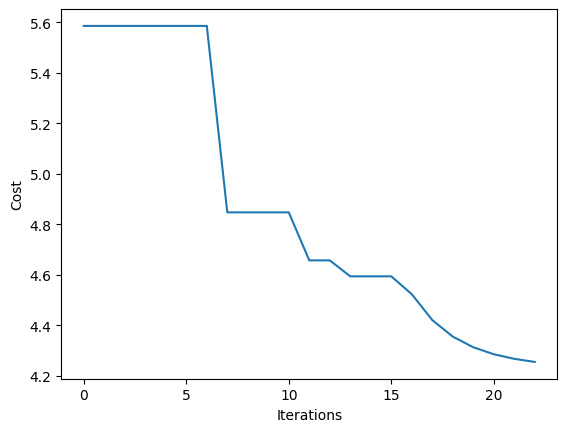

Iteration 23 , Best weight so far:  4.246526092059244 ; L=1.138541495484651 R=0.02674121440024154 t=0.0010746481704047967 S=2003.9824507399007MPa


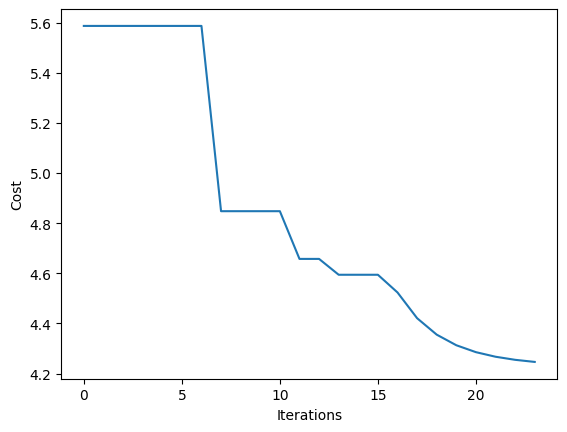

Iteration 24 , Best weight so far:  4.240702208416504 ; L=1.1306218413480205 R=0.026766758302997434 t=0.0010646297597799522 S=2003.6890877316343MPa


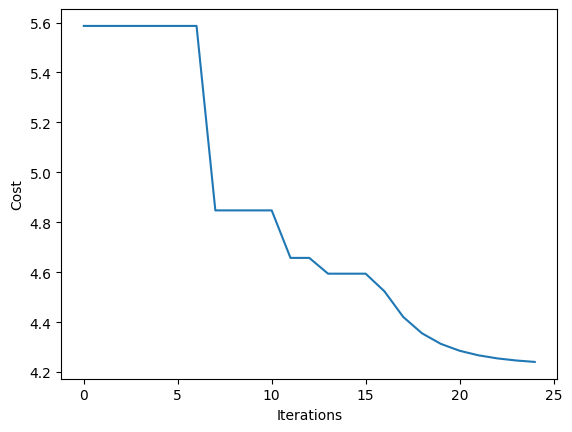

Iteration 25 , Best weight so far:  4.236602335912655 ; L=1.1246821007455476 R=0.026785916230064353 t=0.0010571159518113187 S=2003.5249119512594MPa


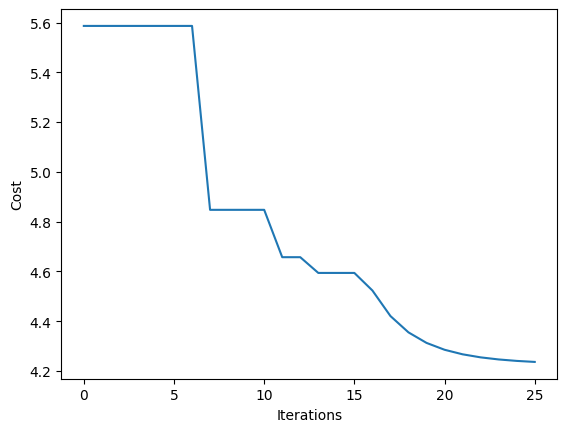

Iteration 26 , Best weight so far:  4.185106257290901 ; L=1.1807829962736986 R=0.0275009838696319 t=0.001026613821656782 S=2048.1782098258996MPa


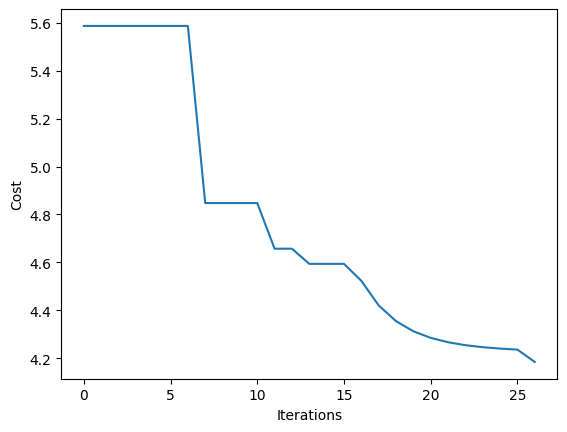

Iteration 27 , Best weight so far:  4.182364490820866 ; L=1.150740883362169 R=0.026687740427057866 t=0.0010408057455456533 S=2095.9428674495566MPa


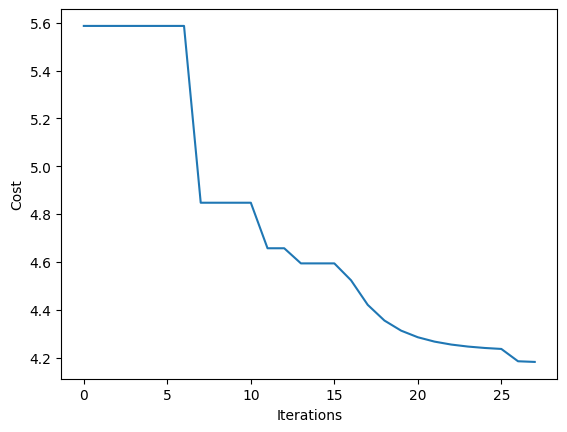

Iteration 28 , Best weight so far:  4.165665265532752 ; L=1.117905766963595 R=0.02673243193019915 t=0.0010055479227758992 S=2096.1076883120572MPa


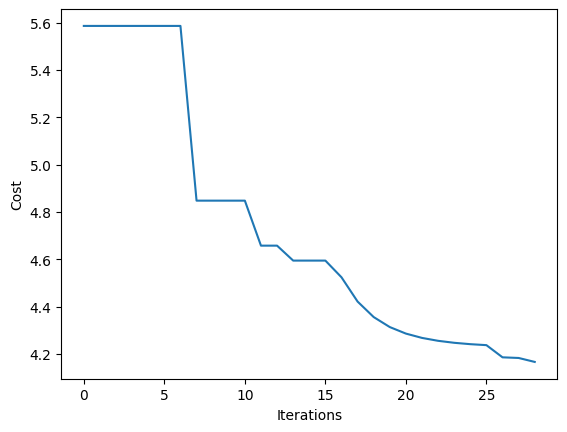

Iteration 29 , Best weight so far:  4.165665265532752 ; L=1.117905766963595 R=0.02673243193019915 t=0.0010055479227758992 S=2096.1076883120572MPa


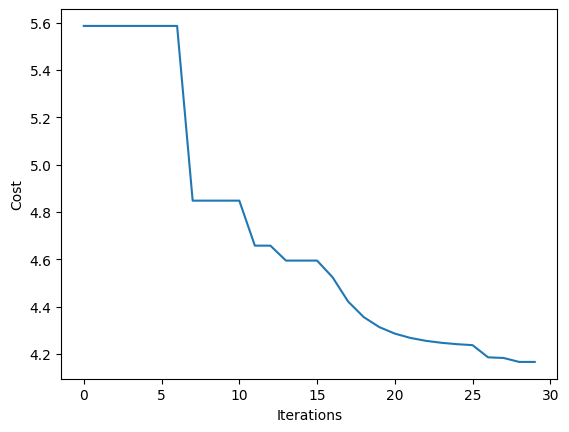

Iteration 30 , Best weight so far:  4.158128569602727 ; L=1.1877550918675643 R=0.027731328882768472 t=0.001004111410319187 S=2068.092847921175MPa


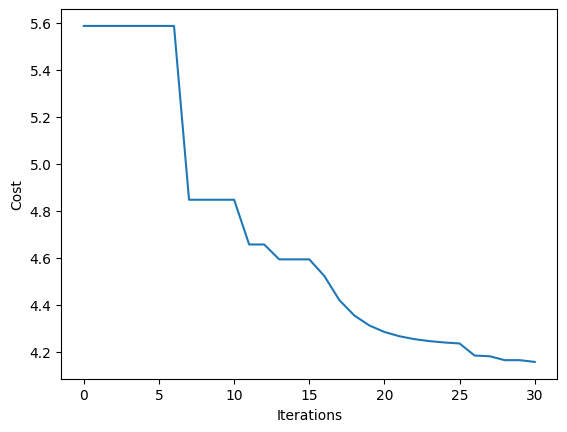

Iteration 31 , Best weight so far:  4.156761286840005 ; L=1.13830564649655 R=0.026983602488040364 t=0.0010039958277760486 S=2096.7570273054516MPa


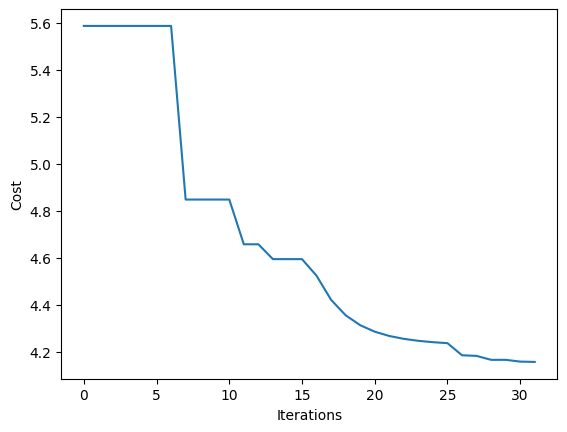

Iteration 32 , Best weight so far:  4.156761286840005 ; L=1.13830564649655 R=0.026983602488040364 t=0.0010039958277760486 S=2096.7570273054516MPa


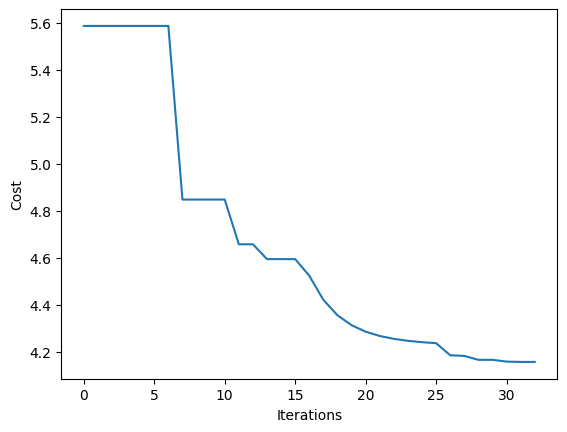

Iteration 33 , Best weight so far:  4.156761286840005 ; L=1.13830564649655 R=0.026983602488040364 t=0.0010039958277760486 S=2096.7570273054516MPa


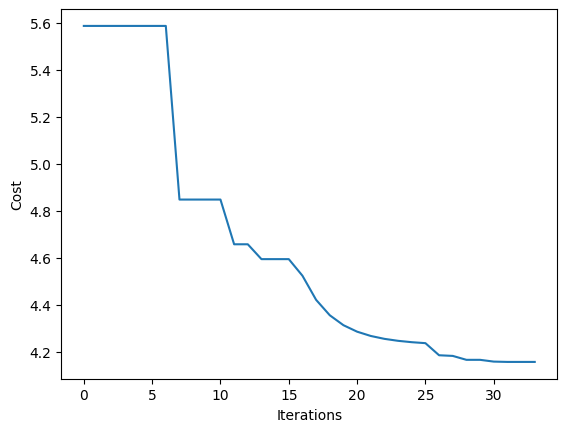

Iteration 34 , Best weight so far:  4.156761286840005 ; L=1.13830564649655 R=0.026983602488040364 t=0.0010039958277760486 S=2096.7570273054516MPa


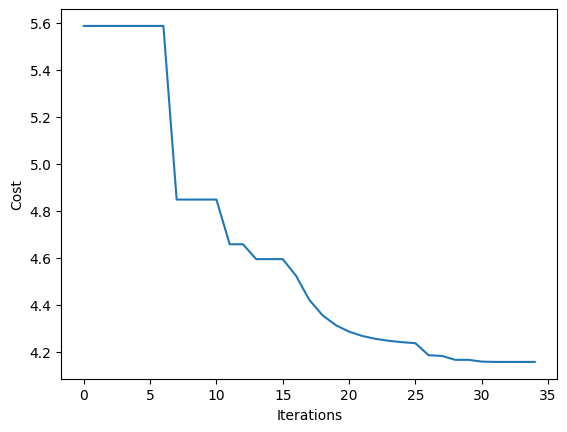

Iteration 35 , Best weight so far:  4.154727023646892 ; L=1.1718149019594741 R=0.027313490344036507 t=0.0010098293389754634 S=2093.7417036653574MPa


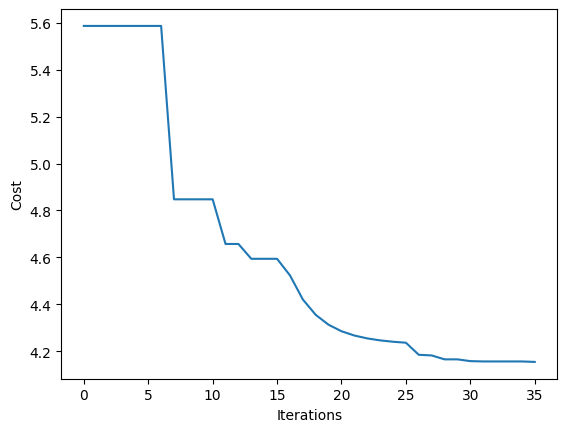

Iteration 36 , Best weight so far:  4.154727023646892 ; L=1.1718149019594741 R=0.027313490344036507 t=0.0010098293389754634 S=2093.7417036653574MPa


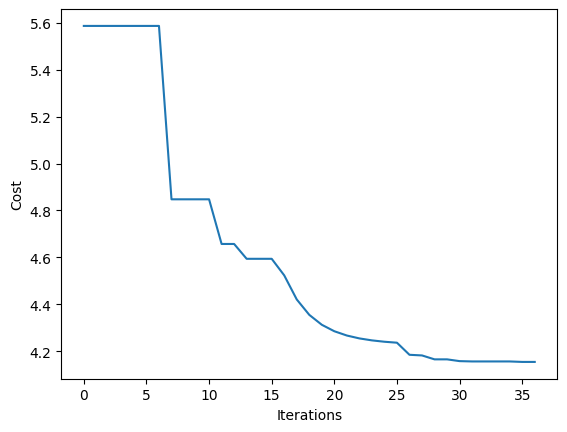

Iteration 37 , Best weight so far:  4.154727023646892 ; L=1.1718149019594741 R=0.027313490344036507 t=0.0010098293389754634 S=2093.7417036653574MPa


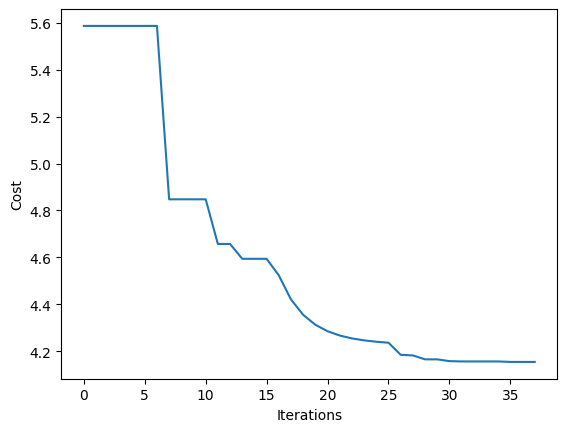

Iteration 38 , Best weight so far:  4.154727023646892 ; L=1.1718149019594741 R=0.027313490344036507 t=0.0010098293389754634 S=2093.7417036653574MPa


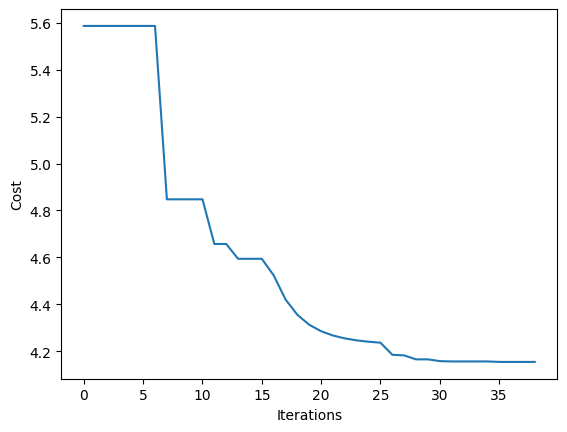

Iteration 39 , Best weight so far:  4.152876834667648 ; L=1.1451758276169541 R=0.027064080170549887 t=0.0010027252480577452 S=2099.043350095483MPa


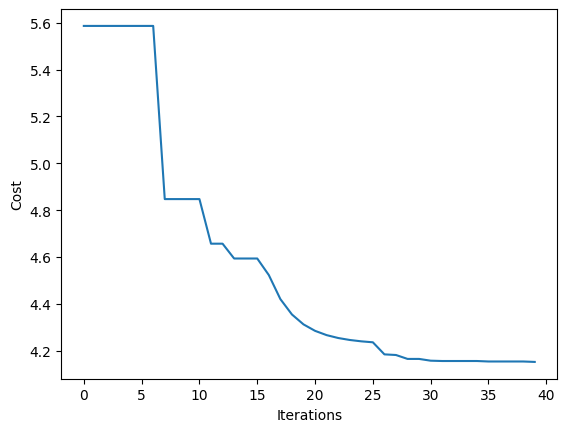

Iteration 40 , Best weight so far:  4.150638928126581 ; L=1.1797677170841516 R=0.027589920990474106 t=0.0010008181125023639 S=2082.3331651822955MPa


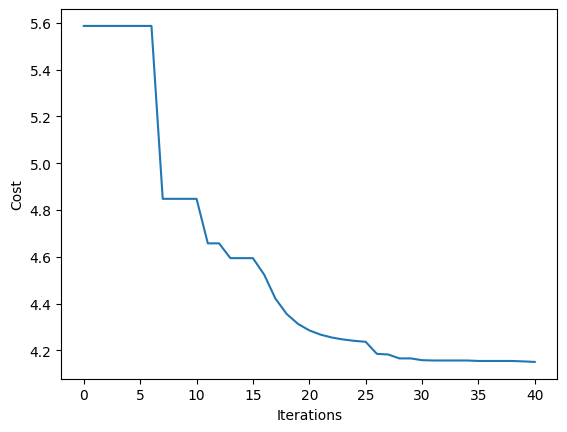

Iteration 41 , Best weight so far:  4.150638928126581 ; L=1.1797677170841516 R=0.027589920990474106 t=0.0010008181125023639 S=2082.3331651822955MPa


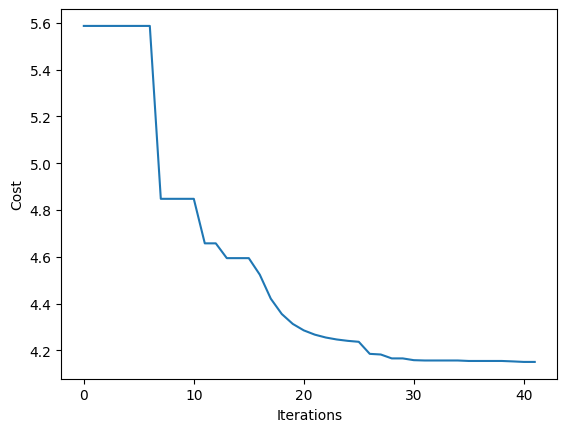

Iteration 42 , Best weight so far:  4.149446079858707 ; L=1.1568003627511056 R=0.027204718831282178 t=0.0010021547917814157 S=2099.005692605866MPa


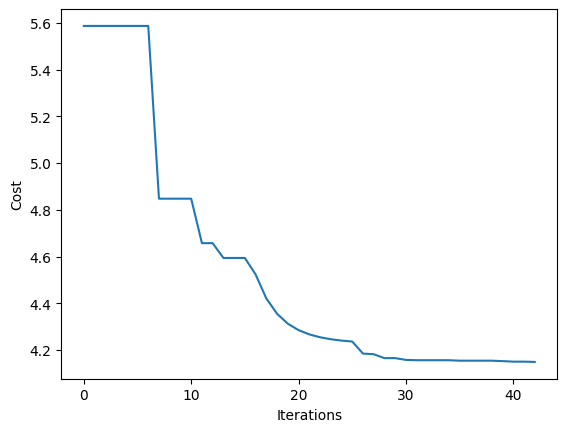

Iteration 43 , Best weight so far:  4.148479819989061 ; L=1.160674836826451 R=0.027252123918298024 t=0.0010019636229108096 S=2098.8906580488683MPa


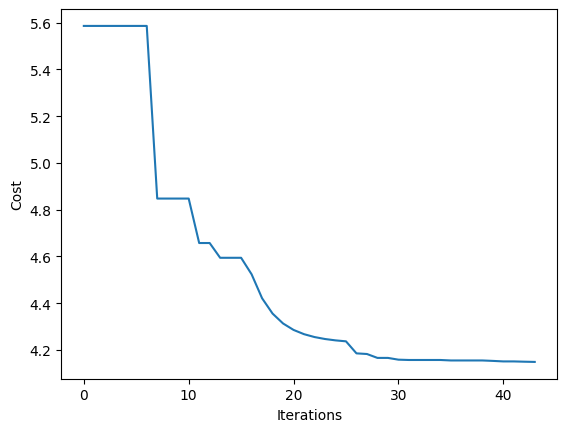

Iteration 44 , Best weight so far:  4.147803122587443 ; L=1.1635806923829601 R=0.02728767773355991 t=0.0010018202462578549 S=2098.7979325457823MPa


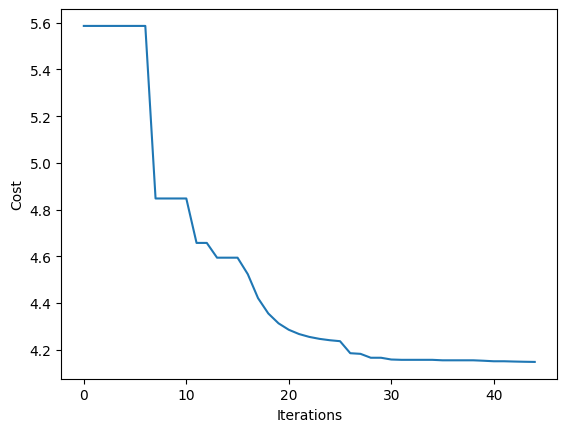

Iteration 45 , Best weight so far:  4.147322431546783 ; L=1.165760084050342 R=0.027314343095006324 t=0.0010017127137681389 S=2098.72479161319MPa


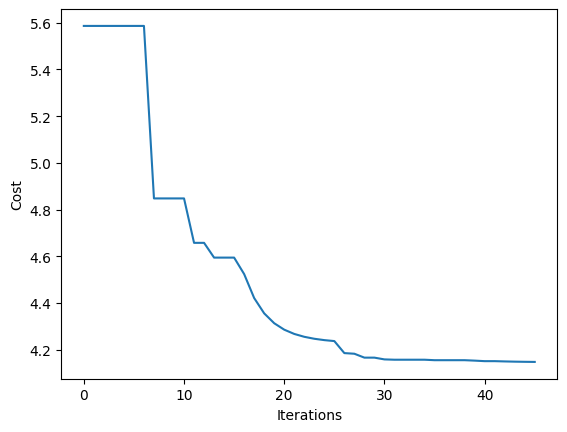

Iteration 46 , Best weight so far:  4.146976936620994 ; L=1.1673946278008782 R=0.027334342116091134 t=0.0010016320644008518 S=2098.667925728272MPa


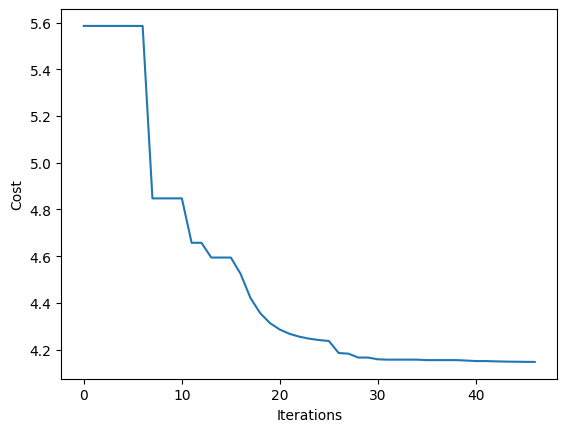

Iteration 47 , Best weight so far:  4.146726236875716 ; L=1.1686205356137804 R=0.027349341381904743 t=0.0010015715773753866 S=2098.624151046515MPa


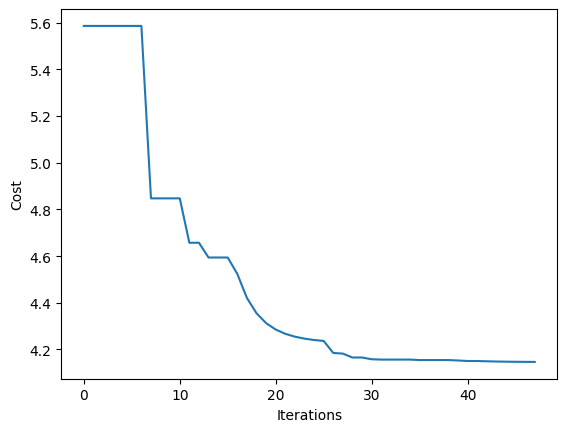

Iteration 48 , Best weight so far:  4.146542936879759 ; L=1.1695399664734571 R=0.02736059083126495 t=0.0010015262121062876 S=2098.5906893662736MPa


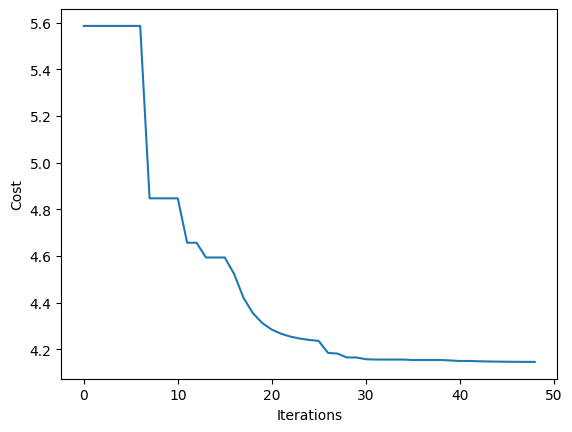

Iteration 49 , Best weight so far:  4.146408114440638 ; L=1.1702295396182147 R=0.027369027918285105 t=0.0010014921881544635 S=2098.5652393197365MPa


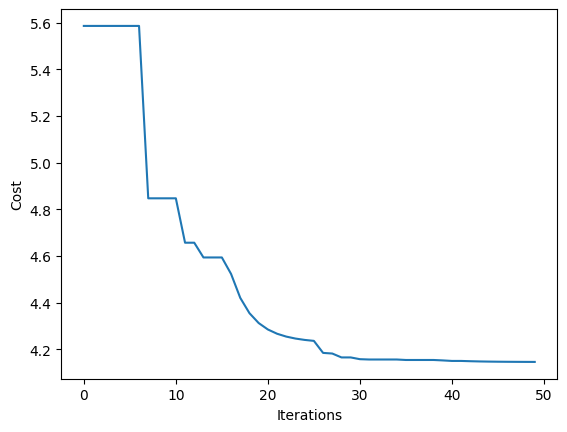

Iteration 50 , Best weight so far:  4.146025643022044 ; L=1.1690512713742984 R=0.027379155470070117 t=0.0010002221686141602 S=2097.3719553496453MPa


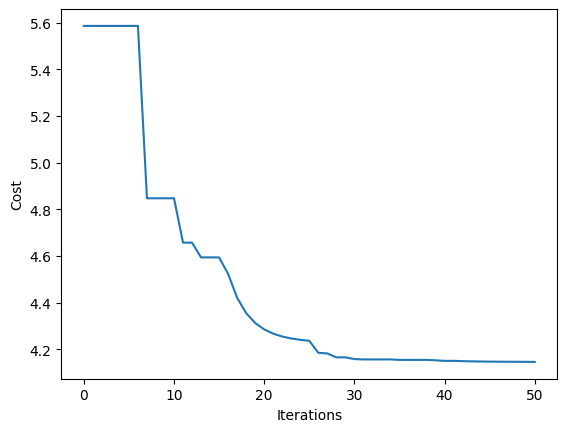

Iteration 51 , Best weight so far:  4.145570710619759 ; L=1.1677390142527693 R=0.027350158360155762 t=0.001000310801947922 S=2099.409270878464MPa


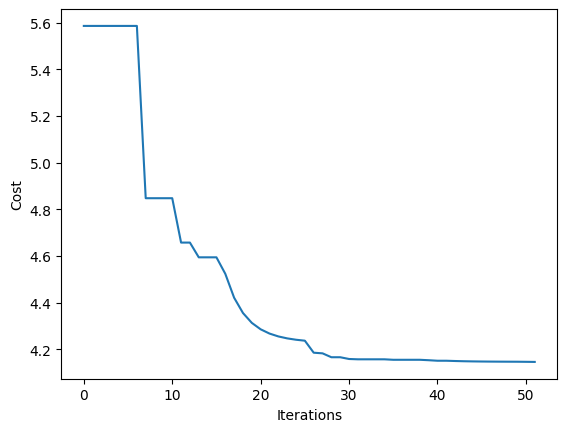

Iteration 52 , Best weight so far:  4.145570710619759 ; L=1.1677390142527693 R=0.027350158360155762 t=0.001000310801947922 S=2099.409270878464MPa


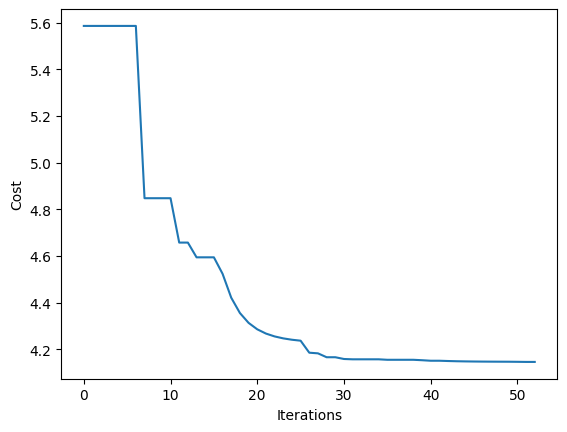

Iteration 53 , Best weight so far:  4.145498603312108 ; L=1.1688859731386563 R=0.027369149472143504 t=0.0010001714838816795 S=2098.7518069846724MPa


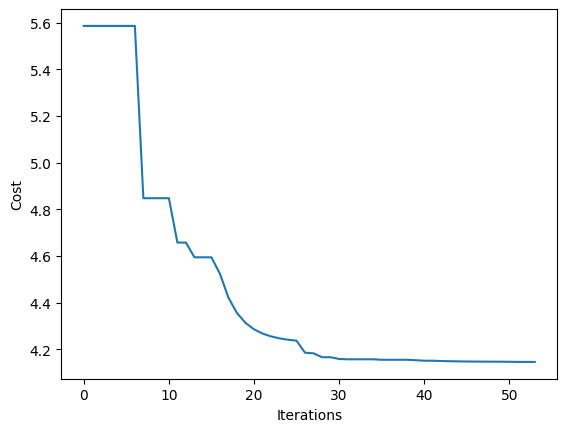

Iteration 54 , Best weight so far:  4.145498603312108 ; L=1.1688859731386563 R=0.027369149472143504 t=0.0010001714838816795 S=2098.7518069846724MPa


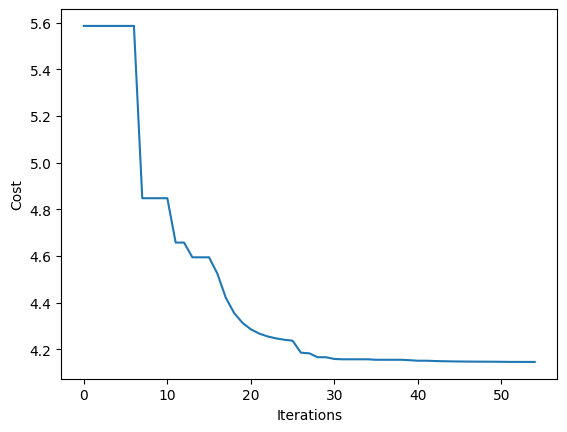

Iteration 55 , Best weight so far:  4.145470326707734 ; L=1.1742523061774877 R=0.027410501701692683 t=0.0010014613697878517 S=2099.2974044600037MPa


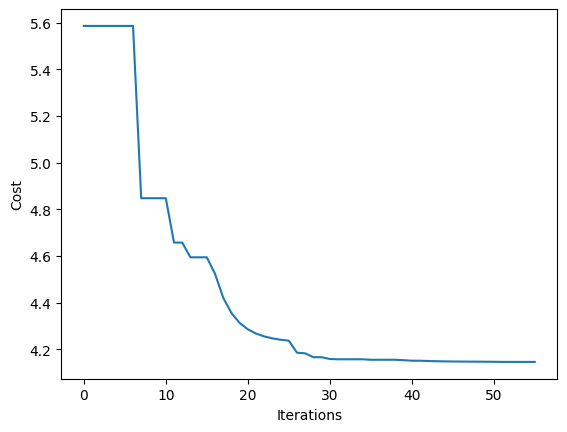

Iteration 56 , Best weight so far:  4.145290427591533 ; L=1.1747215488606053 R=0.027418219420609843 t=0.0010013002021501368 S=2099.240830792744MPa


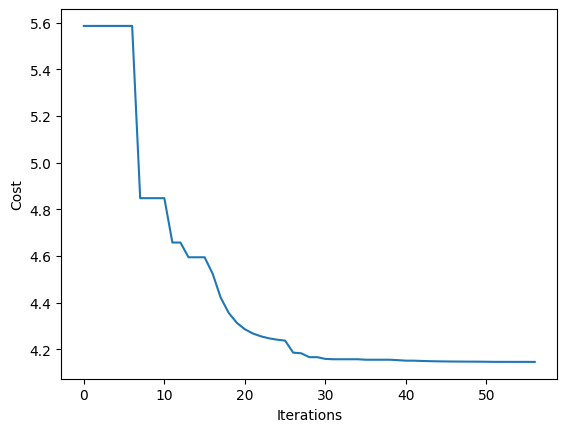

Iteration 57 , Best weight so far:  4.1451560481652185 ; L=1.1750734808729435 R=0.02742400770979771 t=0.0010011793264218505 S=2099.198454701674MPa


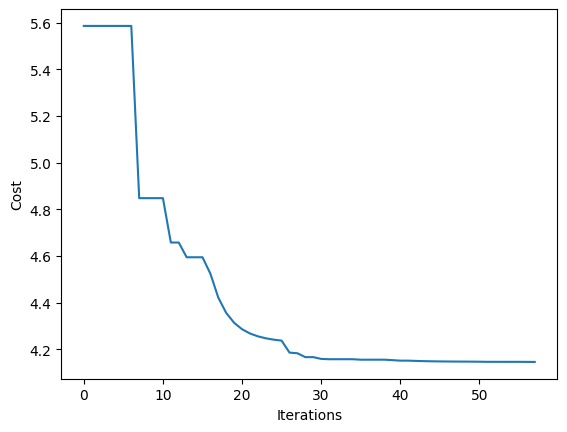

Iteration 58 , Best weight so far:  4.145055569779455 ; L=1.1753374298821972 R=0.027428348926688613 t=0.001001088669625636 S=2099.166703116987MPa


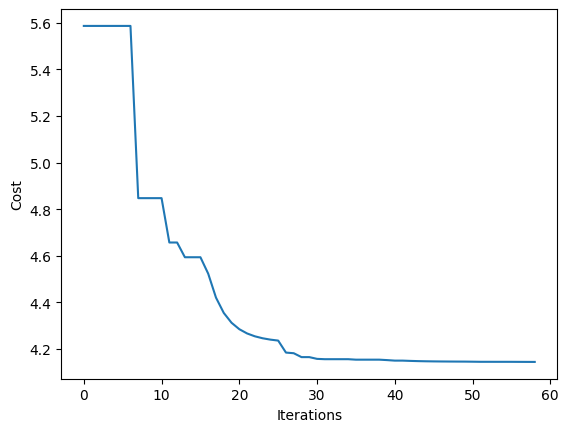

Iteration 59 , Best weight so far:  4.144732128482951 ; L=1.1715008316954203 R=0.02739017516562011 t=0.0010002948278548366 S=2099.8851230586342MPa


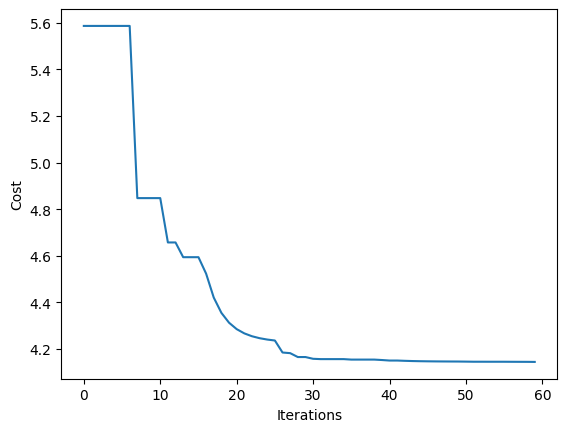

Iteration 60 , Best weight so far:  4.1446355553972305 ; L=1.1719228012140588 R=0.027397404284068397 t=0.001000184857596696 S=2099.720686349593MPa


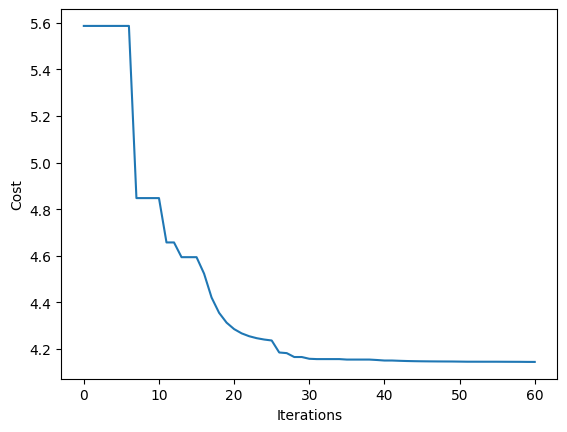

Iteration 61 , Best weight so far:  4.144548955372978 ; L=1.1709955600917366 R=0.027387602581775257 t=0.001000002832521843 S=2099.963876691779MPa


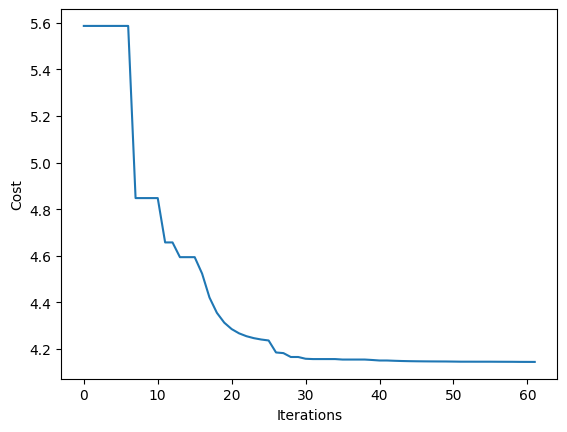

Iteration 62 , Best weight so far:  4.144538969603934 ; L=1.1716235723428947 R=0.027394319867810026 t=0.0010000793135283073 S=2099.879701065311MPa


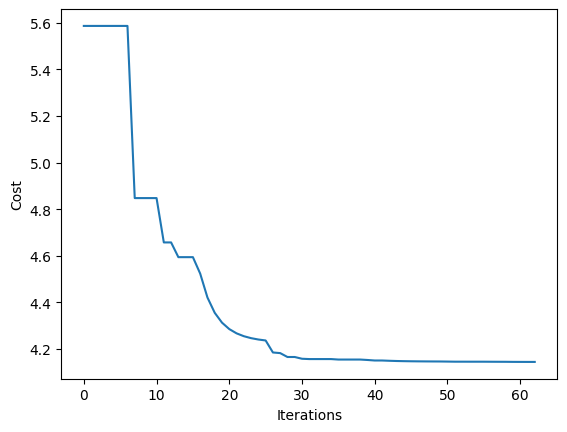

Iteration 63 , Best weight so far:  4.144353876565587 ; L=1.174103808662519 R=0.027421711688021242 t=0.0010002422369749186 S=2099.6842499591894MPa


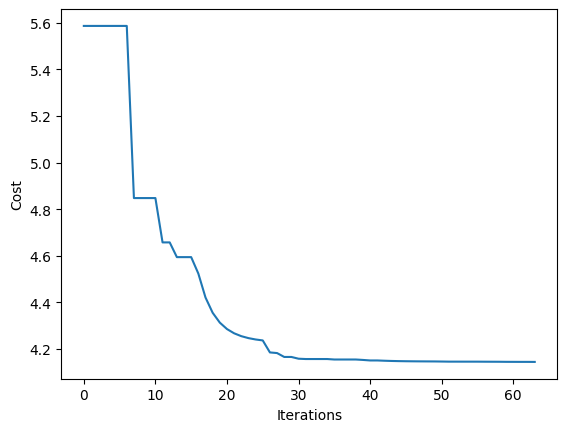

Iteration 64 , Best weight so far:  4.144353876565587 ; L=1.174103808662519 R=0.027421711688021242 t=0.0010002422369749186 S=2099.6842499591894MPa


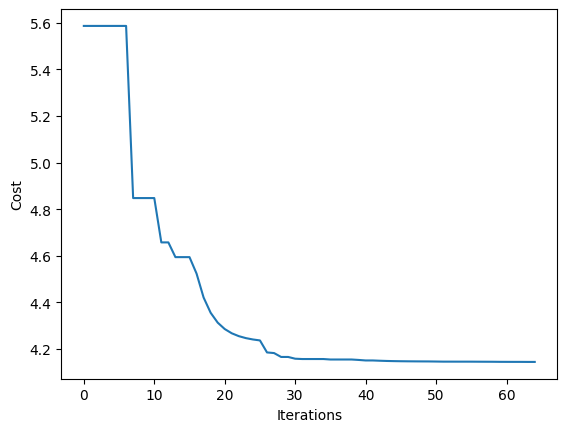

Iteration 65 , Best weight so far:  4.144261846368943 ; L=1.1754508371312768 R=0.027435037178134024 t=0.001000386472354381 S=2099.7094059553224MPa


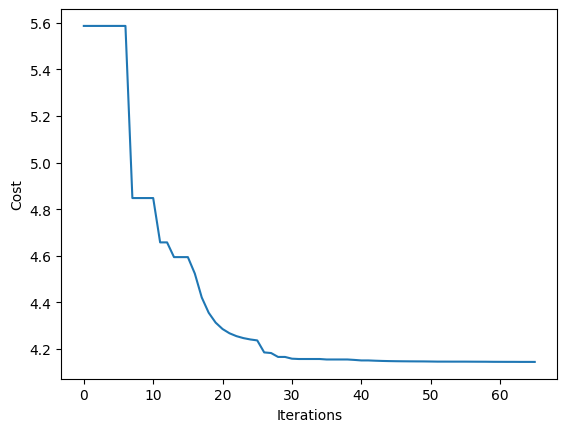

Iteration 66 , Best weight so far:  4.1439853740156956 ; L=1.1769709966104567 R=0.027453574300750693 t=0.001000299508969561 S=2099.6811493114624MPa


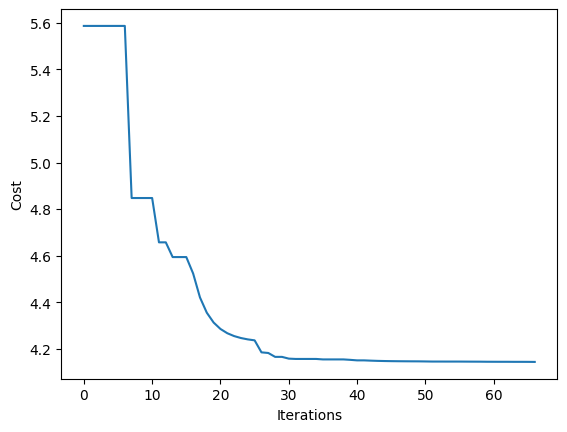

Iteration 67 , Best weight so far:  4.143785105932967 ; L=1.1781111162198414 R=0.027467477142713196 t=0.001000234286430946 S=2099.6590031515298MPa


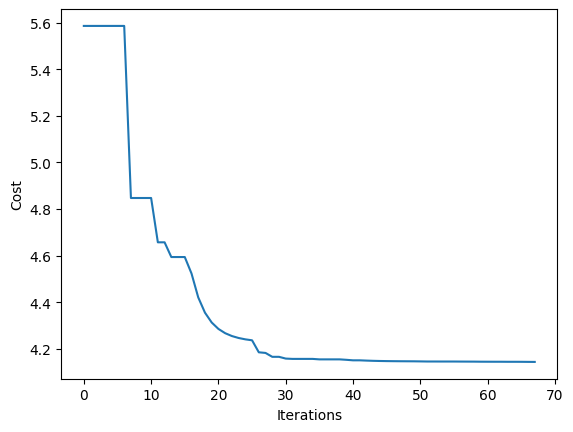

Iteration 68 , Best weight so far:  4.143638881274191 ; L=1.17896620592688 R=0.02747790427418507 t=0.0010001853695269848 S=2099.6418588741685MPa


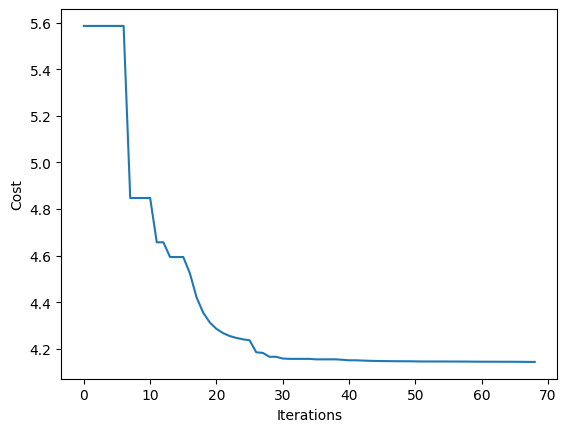

Iteration 69 , Best weight so far:  4.143531445481752 ; L=1.179607523207159 R=0.02748572462278898 t=0.0010001486818490138 S=2099.628700672628MPa


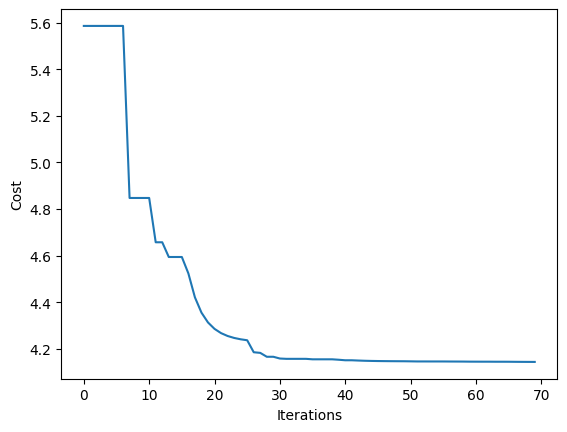

Iteration 70 , Best weight so far:  4.143452122838354 ; L=1.1800885111673682 R=0.02749158988424191 t=0.0010001211660905357 S=2099.618663591365MPa


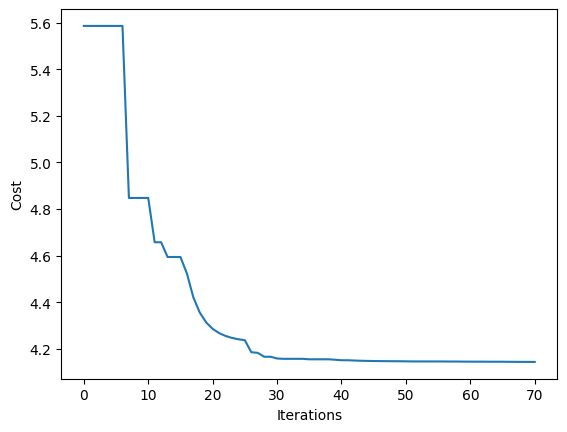

Iteration 71 , Best weight so far:  4.143393335630659 ; L=1.1804492521375252 R=0.027495988830331608 t=0.0010001005292716771 S=2099.611041171693MPa


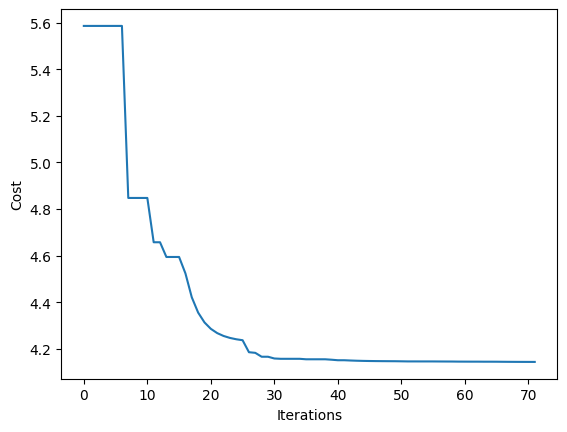

Iteration 72 , Best weight so far:  4.143349641360312 ; L=1.1807198078651429 R=0.027499288039898883 t=0.0010000850516575332 S=2099.6052711956613MPa


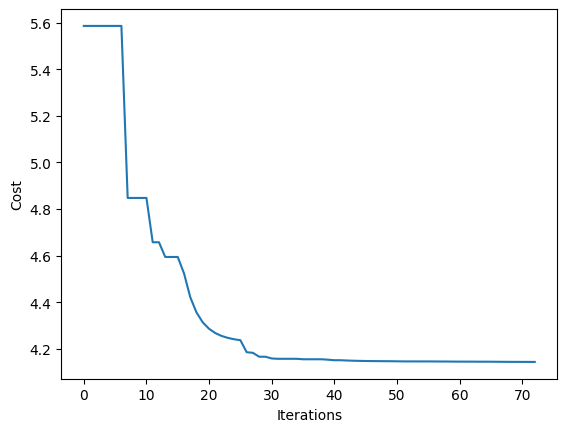

Iteration 73 , Best weight so far:  4.1433170933571315 ; L=1.180922724660856 R=0.02750176244707434 t=0.0010000734434469252 S=2099.60091383407MPa


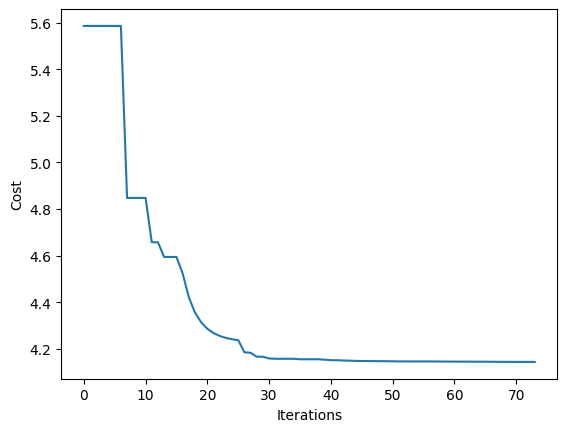

Iteration 74 , Best weight so far:  4.143292807569882 ; L=1.181074912257641 R=0.027503618252455928 t=0.0010000647372889692 S=2099.5976290155986MPa


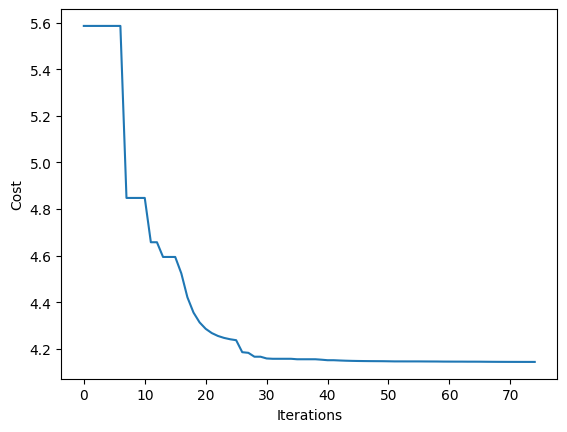

Iteration 75 , Best weight so far:  4.143274663640461 ; L=1.1811890529552296 R=0.02750501010649212 t=0.0010000582076705022 S=2099.59515595748MPa


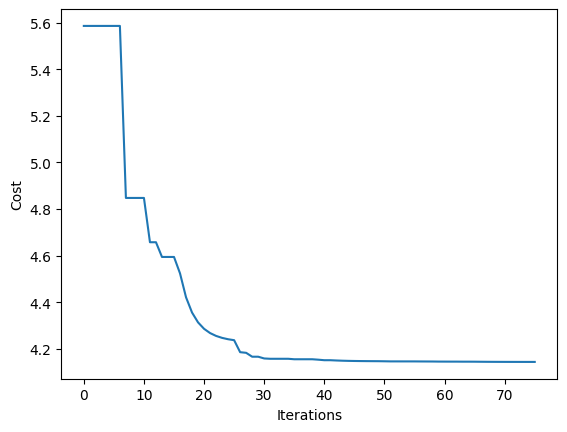

Iteration 76 , Best weight so far:  4.143261095290106 ; L=1.181274658478421 R=0.027506053997019265 t=0.001000053310456652 S=2099.5932958532658MPa


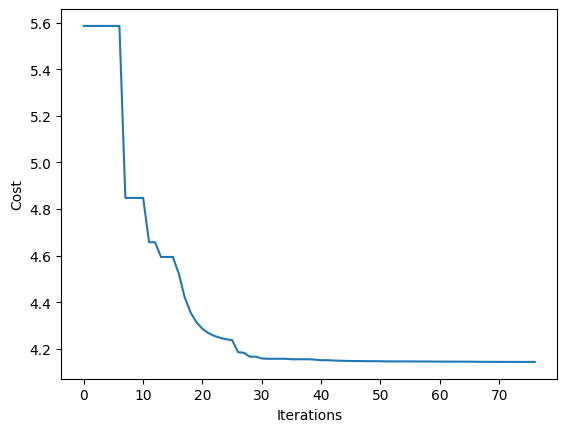

Iteration 77 , Best weight so far:  4.143250941296491 ; L=1.1813388626208148 R=0.027506836914914623 t=0.0010000496375462643 S=2099.5918977886204MPa


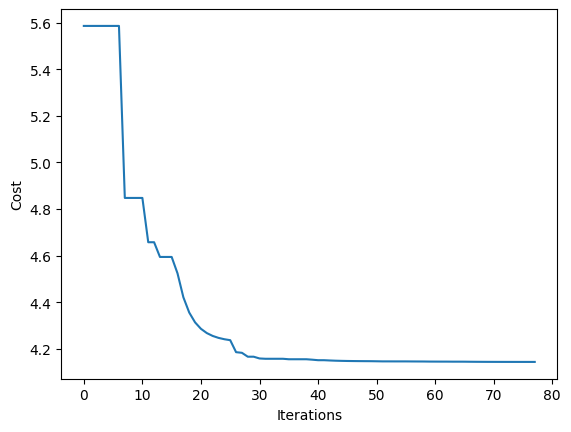

Iteration 78 , Best weight so far:  4.143243338325984 ; L=1.18138701572761 R=0.02750742410333614 t=0.0010000468828634736 S=2099.59084756056MPa


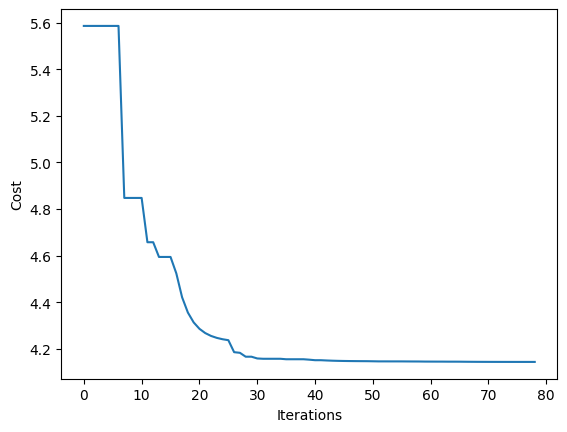

Iteration 79 , Best weight so far:  4.143212946278621 ; L=1.180960350628395 R=0.027502234899184855 t=0.001000008399117446 S=2099.7227672014524MPa


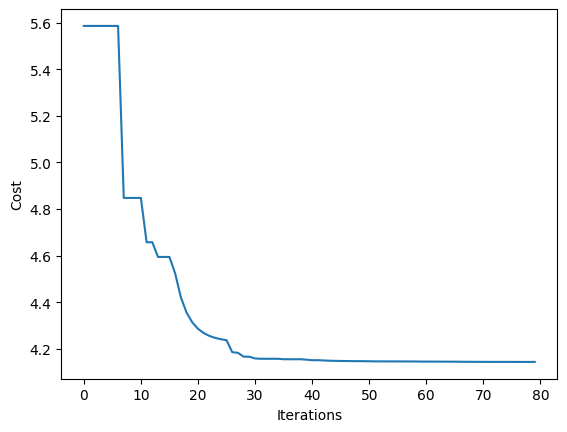

Iteration 80 , Best weight so far:  4.143183394084089 ; L=1.1814893836051437 R=0.027508289307539503 t=0.001000027645998957 S=2099.6752465927575MPa


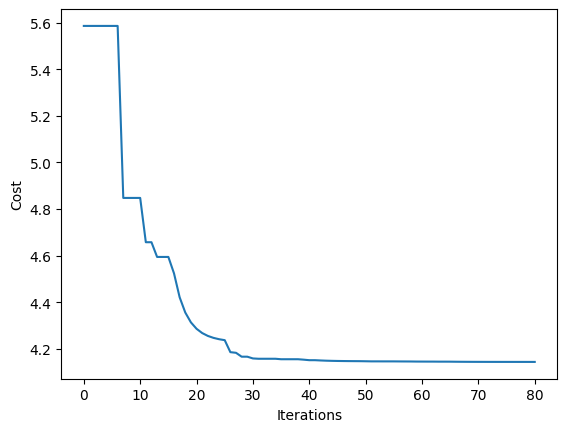

Iteration 81 , Best weight so far:  4.1431336149161435 ; L=1.1820665357701234 R=0.0275151554548015 t=0.0010000266652102827 S=2099.6258510949256MPa


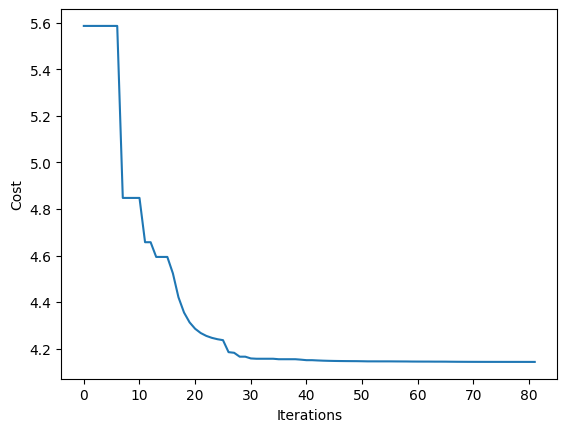

Iteration 82 , Best weight so far:  4.143081496518524 ; L=1.1824417794970123 R=0.027519710243364203 t=0.001000009529656589 S=2099.6121418900643MPa


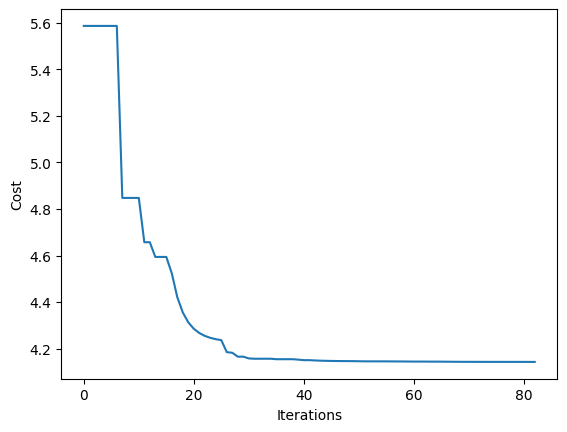

Iteration 83 , Best weight so far:  4.143081496518524 ; L=1.1824417794970123 R=0.027519710243364203 t=0.001000009529656589 S=2099.6121418900643MPa


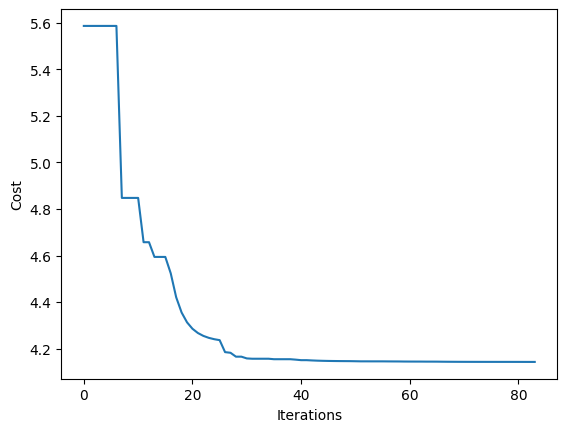

Iteration 84 , Best weight so far:  4.143057195835086 ; L=1.1825291877350552 R=0.02752039800665633 t=0.0010000118371398478 S=2099.654943853064MPa


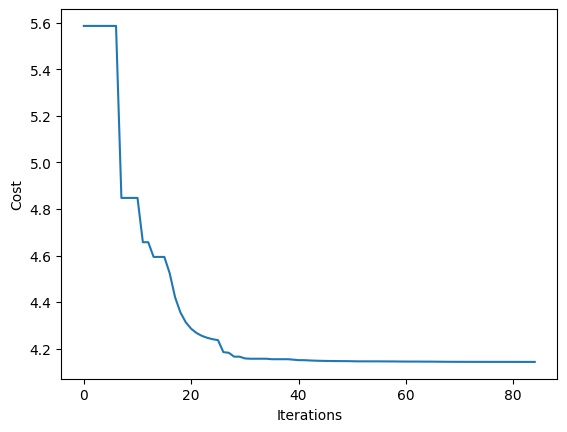

Iteration 85 , Best weight so far:  4.143035386230069 ; L=1.182707650292908 R=0.02752258931656741 t=0.001000004438188855 S=2099.6429547658636MPa


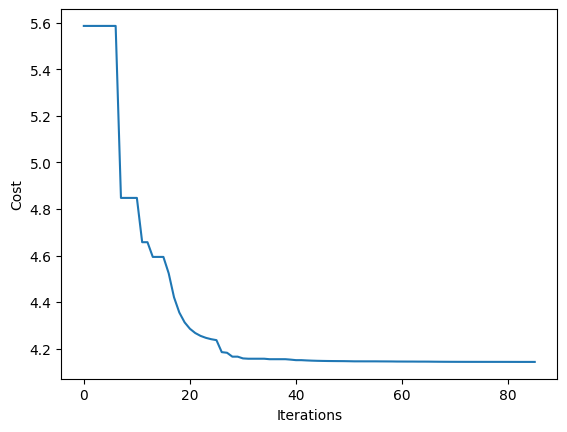

Iteration 86 , Best weight so far:  4.1430319747395155 ; L=1.1821298348417348 R=0.0275148772716766 t=0.0010000043421657184 S=2099.8262103921425MPa


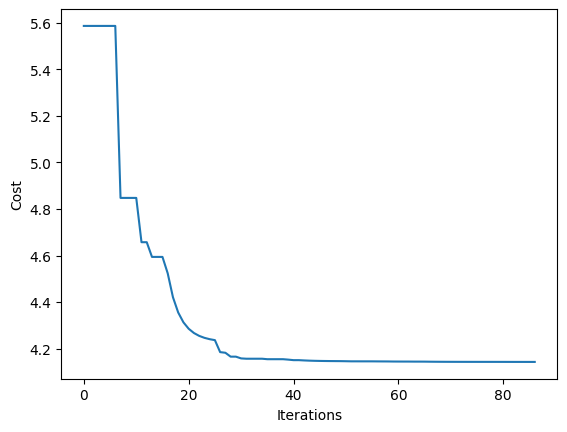

Iteration 87 , Best weight so far:  4.143022963815569 ; L=1.1827796438112226 R=0.02752344298761329 t=0.001000000271560707 S=2099.645211587769MPa


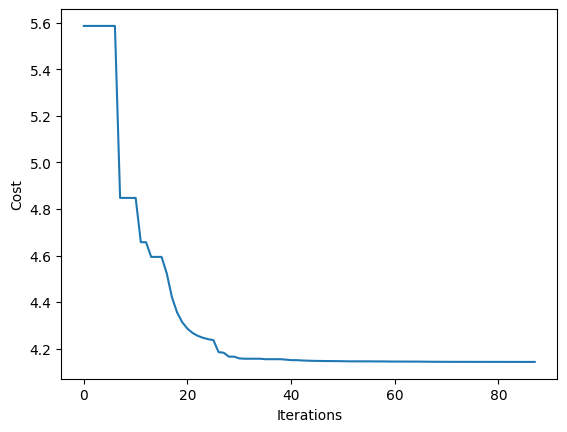

Iteration 88 , Best weight so far:  4.143008167012855 ; L=1.1826271459601712 R=0.027521168515012528 t=0.0010000005827085342 S=2099.7304121666034MPa


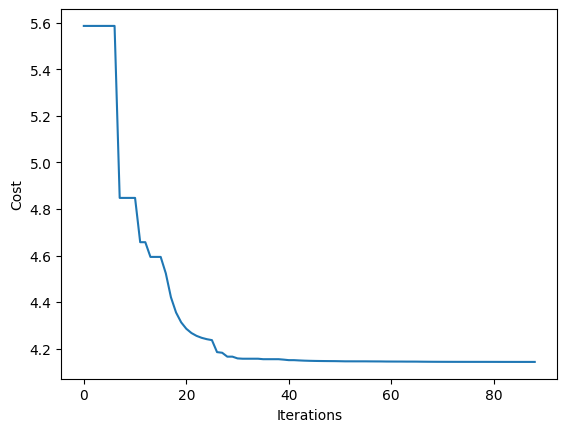

Iteration 89 , Best weight so far:  4.143004788660534 ; L=1.1830416553317744 R=0.027526367618653846 t=0.0010000089875879803 S=2099.6345611953866MPa


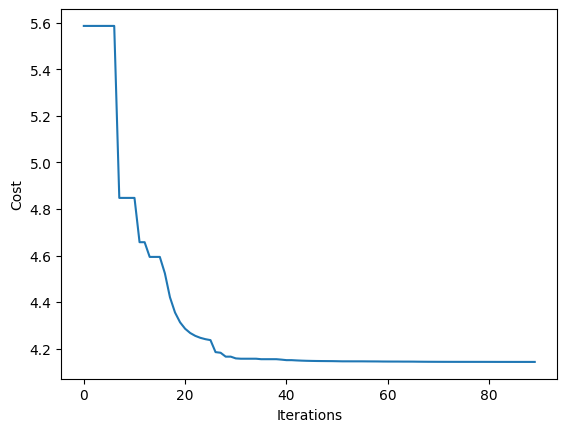

Iteration 90 , Best weight so far:  4.142978159699358 ; L=1.183248459738737 R=0.02752868415512543 t=0.001000007625408989 S=2099.6411978961005MPa


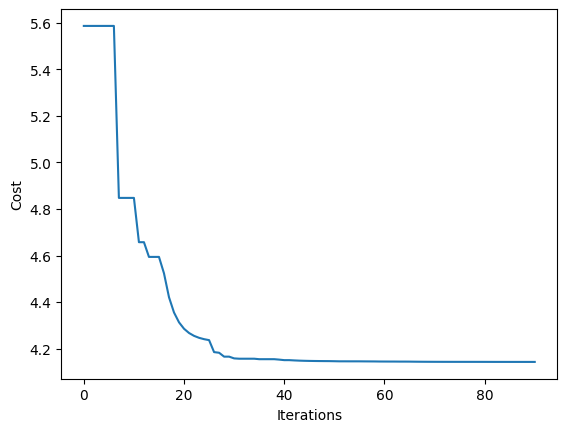

Iteration 91 , Best weight so far:  4.1429497348277415 ; L=1.1834742687338375 R=0.027531259130242996 t=0.0010000046874036356 S=2099.6441469148012MPa


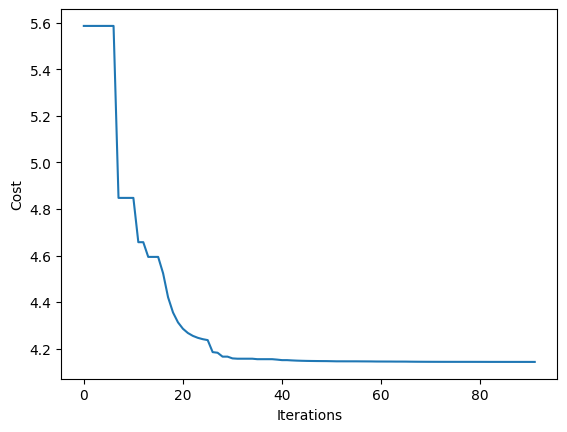

Iteration 92 , Best weight so far:  4.142915142121836 ; L=1.1838278404348819 R=0.027535371425785726 t=0.0010000030306629845 S=2099.6302498531904MPa


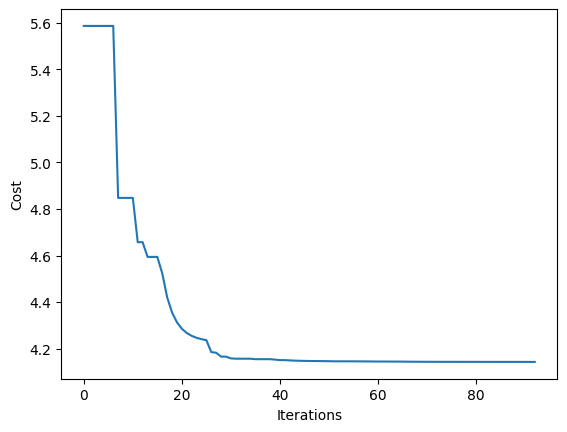

Iteration 93 , Best weight so far:  4.142867605719742 ; L=1.1843301031273425 R=0.027541144000173667 t=0.0010000036476799454 S=2099.6152865663707MPa


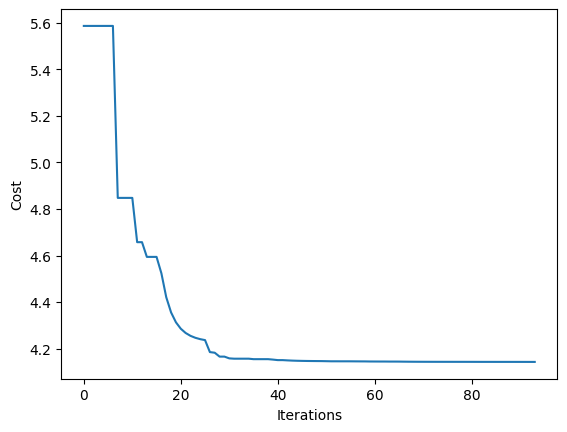

Iteration 94 , Best weight so far:  4.142832743532218 ; L=1.184706800146688 R=0.027545473430964623 t=0.0010000041104426662 S=2099.603944038781MPa


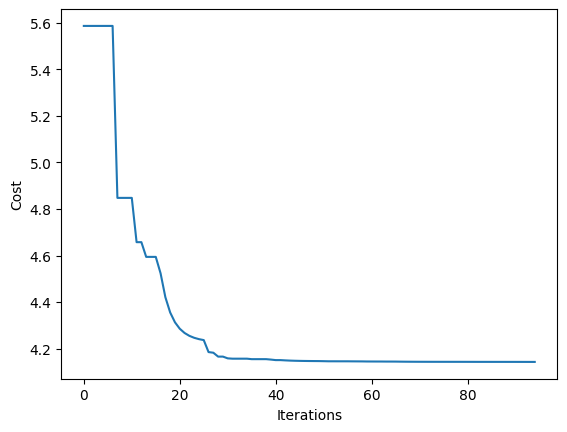

Iteration 95 , Best weight so far:  4.142807041001171 ; L=1.1849893229111972 R=0.02754872050405784 t=0.0010000044575147068 S=2099.595369676366MPa


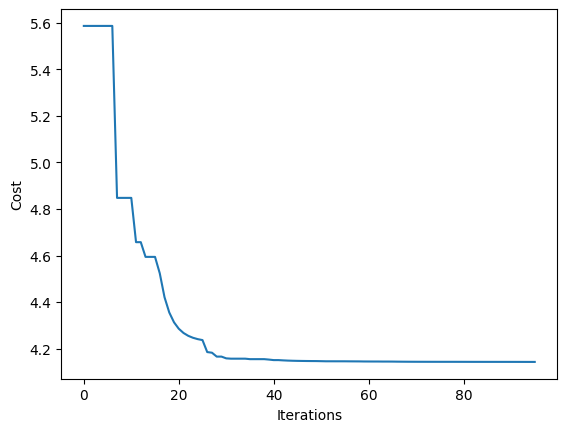

Iteration 96 , Best weight so far:  4.142788013775672 ; L=1.185201214984579 R=0.02755115580887775 t=0.0010000047178187373 S=2099.588900983352MPa


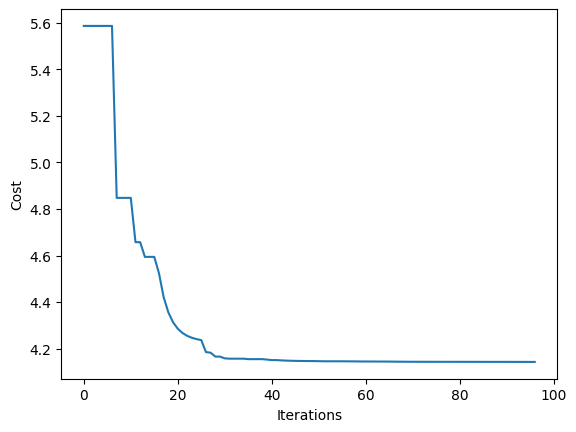

Iteration 97 , Best weight so far:  4.142764815379131 ; L=1.185472079252281 R=0.02755431777523956 t=0.0010000037232904407 S=2099.575564861699MPa


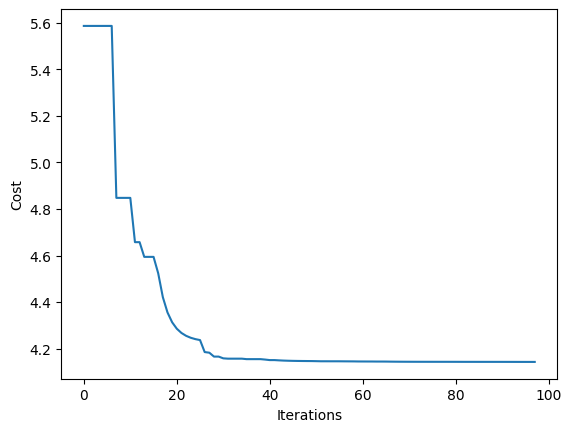

Iteration 98 , Best weight so far:  4.142739353444102 ; L=1.1857656781965185 R=0.027557697343827306 t=0.0010000039958438405 S=2099.565853192684MPa


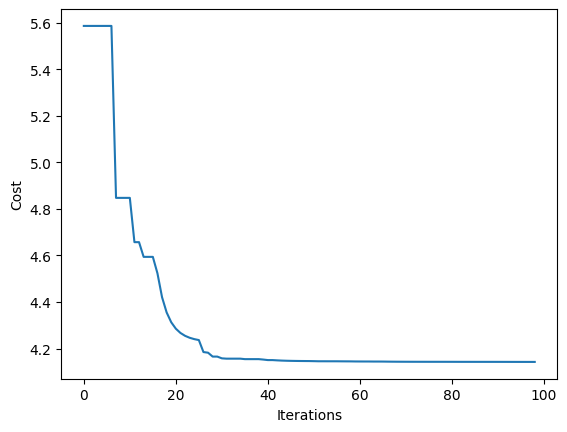

Iteration 99 , Best weight so far:  4.142720526258279 ; L=1.1859858774046965 R=0.027560232020268118 t=0.0010000042002588903 S=2099.558528710678MPa


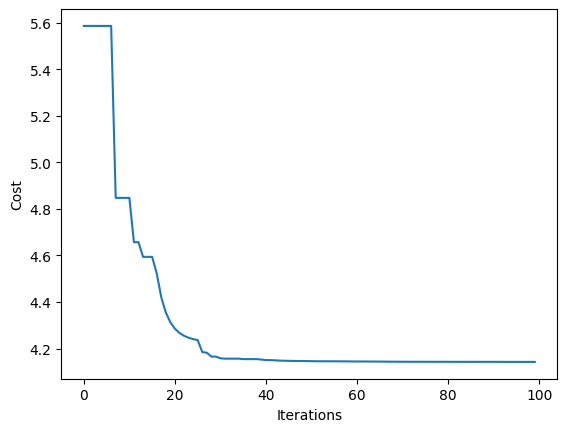


PSO found a solution after 49 iterations:
W = 4.143 Kg
L = 1.186 m
R = 27.56 mm
t = 1.0 mm
S = 2099.559 MPa


In [6]:
#### Hyper-parameter of the algorithm ###
c1 = 0.1
c2 = 0.1
w = 0.75

# Create particles
n_particles = 100
np.random.seed(100)
X = generate_valid_particles(n_particles, x_min, x_max)
V = np.random.randn(ndim, n_particles) * 0.1 # Random initial velocity

# Initialize data
pbest = X # Initialize personal best as first generation
pbest_obj = f(X)

gbest = pbest[:, pbest_obj.argmin()] # Global best particle
gbest_obj = pbest_obj.min()

plt.figure()
G = []

for j in range(100):
    plt.clf()
    # Update params
    r1, r2 = np.random.rand(2)
    
    # V = inertia + cognitive + social
    V = w * V + c1*r1*(pbest - X) + c2*r2*(gbest.reshape(-1,1)-X)
    
    # X_now = X_old + V
    X_temp = X + V
    
    for i in range(n_particles): # Check for constraints
        if np.all(X_temp[:,i] > x_min.reshape(-1,)) and np.all(X_temp[:,i] < x_max.reshape(-1,)) and Stress(X_temp[:,i]) < max_stress:
            X[:,i] = X_temp[:,i].copy()
    
    # calculate the weights of the updated particles
    obj = f(X)
    
    # calculate the pbest and gbest
    pbest[:, (pbest_obj >= obj)] = X[:, (pbest_obj >= obj) ] # Update for each particle personal best
    pbest_obj = np.array([pbest_obj, obj]).min(axis=0)
    
    gbest = pbest[:, pbest_obj.argmin()] # Update global minimum
    gbest_obj = pbest_obj.min()
    print('Iteration', j, ', Best weight so far: ', gbest_obj, '; L=' + str(gbest[0]), 'R=' + str(gbest[1]), 't=' + str(gbest[2]), 'S=' + str(Stress(gbest)*1e-6) + 'MPa')
    G.append(gbest_obj)

    plt.plot(G)
    plt.ylabel('Cost')
    plt.xlabel('Iterations')
    plt.pause(0.001)

    if j > stop_iter and np.all(np.array(G[-stop_iter:])==G[-1]):
        break

print()
print('PSO found a solution after %d iterations:'%(j-stop_iter))
print('W = ' + str(round(gbest_obj,3)) + ' Kg')
print('L = ' + str(round(gbest[0],3)) + ' m')
print('R = ' + str(round(gbest[1]*1e3,3)) + ' mm')
print('t = ' + str(round(gbest[2]*1e3,3)) + ' mm')
print('S = ' + str(round(Stress(gbest)*1e-6,3)) + ' MPa')
plt.show()


## Summary ##

In this class we covered:

1. Swarm intellegence consept
2. We dived into Particles Swarm Intelligence concepts including:
    - position & velocity explained
    - pbest & gbest explained
    - algorithm parameters explained
    - the update equation
    - PSO cycle
3. We demonstrated PSO algorithm by solving a optimization problem in engineering domain

---

## Helpful and extra links ##

1. [Particle Swarm Optimization (PSO) Visually Explained](https://towardsdatascience.com/particle-swarm-optimization-visually-explained-46289eeb2e14) <-- recomended
2. [A Gentle Introduction to Particle Swarm Optimization
](https://machinelearningmastery.com/a-gentle-introduction-to-particle-swarm-optimization/)

---